In [386]:
import numpy as np
import matplotlib.pyplot as py
import scipy.interpolate as spin
import scipy.signal as spsi
import pytdi.michelson as tdiM

The data needs to be extracted from the downloaded file, automatically named as ACE_SWICS_Proton_Data. The values in this case were taken from 2024, between days 32 and 38, written as 24/32 and 24/37 on the website. The velocity, time, and density values are stored in vels, fracday, and densities respectively. 

In [387]:
with open("C:\\Users\\User\\Downloads\\ACE_SWICS_Proton_Data.txt", 'r') as f:
    lines = f.readlines()

startidx = lines.index('BEGIN DATA\n') #data starts after 'BEGIN DATA' line

vels = []
fracday = []
densities = []
for i in lines[(startidx+1):]:
    tempdata = i.strip('\n').split() #per line, remove all newlines, and split row by whitespace
    
    fracday.append(float(tempdata[5])) #the fractional day and density entries have 5th and 6th indices respectively
    densities.append(float(tempdata[6]))
    vels.append(float(tempdata[7]))
    
    if densities[-1] == -9999.9:        #faulty/improper data is set to -9999.9
        #print(len(densities))          #optional, to narrow down when the faulty data occcurs
        densities[-1] = densities[-2]   #set faulty data to previous datapoint
        
    if vels[-1] == -9999.9:        #faulty/improper data is set to -9999.9
        #print(len(vels))          #optional, to narrow down when the faulty data occcurs
        vels[-1] = vels[-2]   #set faulty data to previous datapoint
        
fracday = np.array(fracday)
densities = np.array(densities)
vels = np.array(vels)

The idea is to have the transition line (technically a plane) occur at dist = 0. If the evaluated distance from the plane is 0, we want the transition line from the data to be occurring. However, the data needs to be converted from time to distance, and when that is done, the 'zero point' occurs at the start of that year. Hence, the data's transition line needs to be found by eye, and all values of time need to be subtracted by the time at transition, giving some positive, and some negative values. These will correspond to distances behind and in front of the transition line added by the user. The effect of not doing this subtraction is simply an offset in the time ranges that need to be explored, but becomes convenient when subtracted, since dist=0 always corrensponds to the relevant transition line. The code below is the trial-and-error way of finding the point of transition. 

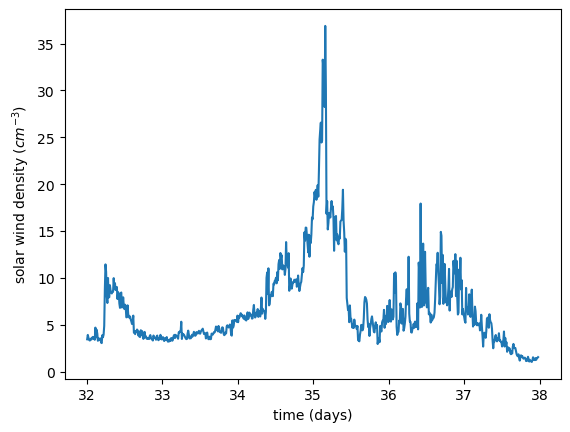

In [388]:
pstart = 0
pend = -1

py.plot(fracday[pstart:pend],densities[pstart:pend]) #transition occurs at approx 32.235 days
py.xlabel('time (days)')
py.ylabel('solar wind density ($cm^{-3}$)')
py.show()

In [389]:
#Verify that all this works properly (use blender, replace real data with sigmoid temporarily). 

Constants are defined below. Last 2 shouldn't be changed, others can be.

In [390]:
v = 600 # wind speed km/s
Wzangle = 0 #angle of wind flow (from x axis)
Wyangle = 0
Lzangle = 0 #angle of the transition line
Lyangle = 0

LISArot1 = [0,0,0.75+np.pi/2] #LISA pre-rotation around z axis - pi/2 because of blender vs python implementation method
LISArot2 = [0,0,0]

timeoftrans = 32.235
#timeoftrans = 35.17

armres = 250 #resolution of each lisa arm
graphres = 1000 #resolution of plotted graphs


highdens = 10
bgdens = 3
sigfalloff = 500

L = 1/60 # lisa arm length in AU
AUtokm = 149600000 #km per AU

Rotation matrix is defined below. The order is X>Y>Z. For the opposite order, use multiple rotation matrices. 

In [391]:
def eulerRot3D(RotObj, Xangle, Yangle, Zangle):
    
    sa = np.sin(Zangle) #sin and cos of x,y,z angles
    ca = np.cos(Zangle)
    sb = np.sin(Yangle)
    cb = np.cos(Yangle)
    sc = np.sin(Xangle)
    cc = np.cos(Xangle)
    
    rotmat = np.array([[ca*cb, ca*sb*sc - sa*cc, ca*sb*cc + sa*sc], [sa*cb, sa*sb*sc + ca*cc, sa*sb*cc - ca*sc], [-sb, cb*sc, cb*cc]])
    
    return np.matmul(rotmat, RotObj)
    

The sigmoid function below acts as a verification tool with blender, as real data is difficult to import into blender.

In [392]:
def sigmoid(x, a, b):
    return 1/(1 + np.exp(a*(x-b))) #returns sigmoid - note the -b, not +b

The function below converts the real, discrete data values into a linearly interpolated function. The real data is given as time, and needs to be converted to a distance by multiplying by a velocity. Currently, this is guesstimated as 600 km/s, but should ideally be the peak velocity of the transition period. 

In [393]:
def realdata(x, fracday, densities, windvelsec, timeoftrans):
    timetodist = windvelsec * (fracday-timeoftrans) * 86400 #convert from time to distance NOTE: VELOCITY MUST BE IN DIST/SECONDS
    return np.interp(x, timetodist, densities)

In [394]:
def realspline(x, fracday, densities, windvelsec, timeoftrans):
    timetodist = windvelsec * (fracday-timeoftrans) * 86400 #convert from time to distance NOTE: VELOCITY MUST BE IN DIST/SECONDS
    spline = spin.CubicSpline(timetodist, densities)
    return spline(x)

Converting from 2D to 3D results in the distance calculation changing. To make it more convenient, the plane's normal vector is supplied as opposed to the previous line angle. This is done by setting a base [1,0,0] vector, defined below. The perpendicular velocity is found by the dot product between the vectors, multiplied by

$$
\hat b = \left [ 
\begin{matrix}
1\\0\\0
\end{matrix}
\right ]
$$

This can then be rotated by the desired angles to get the wind velocity and plane normal vectors. 

$$
\hat n_{plane} = RotMat(0, Py, Pz)
$$

$$
\hat n_{wind} = RotMat(0, Wy, Wz)
$$

Where the rotation matrix is defined in 'finalboy', Py and Pz are the y and z rotations for the plane, and Wy and Wz are the rotations for the wind. The perpendicular velocity is then found as shown below:

$$
v_{perp} = v(\hat n_{wind} \cdot \hat n_{plane})
$$

Multiplying this by time shows how the distance of a point on LISA changes over time, but does not supply the initial distance. To calculate this, the plane should pass through the origin at evaluation, which can be assumed to be t=0. To find the closest distance to the plane, the line from the relevant point to the plane must intersect perpendicularly. This is the negative of the plane's normal vector, $\hat n_{plane}$. A plane can be described as below:

$$
ax + by + cz = ax_0 + by_0 + cz_0
$$

Or in vector form

$$
\bar{a} \cdot \bar{x} = \bar{a} \cdot \bar{x_0} 
$$
Where
$$
\bar{a} = \hat n_{plane}
$$

The equation for a line in 3D is:

$$
\bar{x} = P_0 + K(-\bar{a})
$$

Where $P_0$ is the point on LISA's arm, and K is the parameter detailing position along the line. Since $\bar{a}$ is a unit vector, K is the distance from the plane. Replacing it back into the equation for a plane yields

$$
P_0 \cdot \bar{a} - K(\bar{a} \cdot \bar{a}) = \bar{a} \cdot \bar{x_0} 
$$

$$
P_0 \cdot \bar{a} - K = v_{perp} t
$$

$$
P_0 \cdot \bar{a} - v_{perp} t = K
$$

The first part is the initial or base distance, when the plane passes through the origin. The second part details how the distance changes with time. 

In [395]:
def avgDensLine(armlen, armrot1, armrot2, armres, armidx, time, windvel, windZang, windYang, lineZang, lineYang, fracday, timeoftrans, densities, sigmoidfalloff, highdens, bgdens): #current implementation - wind must be in dist/sec. May be changed
    
    start = np.array([armlen/np.sqrt(3) * np.cos((armidx)*2*np.pi/3), armlen/np.sqrt(3) * np.sin((armidx)*2*np.pi/3), 0]) #defining start and end coordinates of the arm
    end = np.array([armlen/np.sqrt(3) * np.cos((armidx+1)*2*np.pi/3), armlen/np.sqrt(3) * np.sin((armidx+1)*2*np.pi/3), 0])
    
    pos = np.array([start, end]).T #transposed for dimensions
    pos = eulerRot3D(pos, armrot1[0], armrot1[1], armrot1[2]) #rotating points around origin by the specified 'armrot' angle
    pos = eulerRot3D(pos, armrot2[0], armrot2[1], armrot2[2]) #second rotation, since default rotation order is z,y,x
    
    X = np.linspace(pos[0,0], pos[0,1], armres) #subdividing laser arm to the specified resolution
    Y = np.linspace(pos[1,0], pos[1,1], armres)
    Z = np.linspace(pos[2,0], pos[2,1], armres)
    points = np.array([X,Y,Z])
    
    basenorm = np.array([1,0,0]).T #base unit vector pointing in x direction
    
    planenorm = eulerRot3D(basenorm, 0, lineYang, lineZang)
    windnorm = eulerRot3D(basenorm, 0, windYang, windZang)
    
    basedist = np.matmul(points.T, planenorm) #calculating the closest distance of the point from the line
    perpvel = windvel * np.dot(planenorm, windnorm) #velocity perpendicular to line is the dot product between the plane's normal and wind vectors
    
    '''
    fraction = sigmoid(perpvel*time, -sigmoidfalloff, basedist) #this line for testing
    densvect = fraction*highdens + (1-fraction)*bgdens #this line for testing
    '''
    
    densvect = realdata(perpvel*time - basedist, fracday, densities, windvel, timeoftrans)
    #densvect = realspline(perpvel*time - basedist, fracday, densities, windvel, timeoftrans)
        
    avgdens = np.sum(densvect)/armres
    
    return avgdens

In [396]:
def windowfunction(graphres, alpha):
    return spsi.windows.tukey(graphres, alpha)

Evaluates average densities at various times, and stores them in a dictionary.

In [397]:

time = np.linspace(-0.235*86400,0.265*86400, graphres) #set time to evaluate densities #note note: set to 5.265 instead of 0.265 temporarily
#time = np.linspace(-5000,5000, 200)


#timemins = time/60 #time in minutes
#vminsAU = v*60/AUtokm #velocity in au/min
vAU = v/AUtokm #velocity in au/sec

averages = {} #empty dictionary, to hold arm-averagedensity pairs
#averagesWin = {} #holds the averages multiplied by the kaiser window function

for i in range(3): #for each arm
    averages['avgdens'+str(i)] = [] #setting an empty list to fill with averages
    
    for j in time: #for each time division
        averages['avgdens'+str(i)].append(avgDensLine(L, LISArot1, LISArot2, armres, i, j, vAU, Wzangle, Wyangle, Lzangle, Lyangle, fracday, timeoftrans, densities,sigfalloff, highdens, bgdens)) #appending the average to the relevant list
        
    averages['avgdens'+str(i)] = np.array(averages['avgdens'+str(i)]) #converting to array
    #averages['avgdens'+str(i)] = averages['avgdens'+str(i)] * windowfunction(graphres, 0.2) #multiplies by window function

    #note - maybe use 'averages' for normalization, and 'averagesWin' for everything else?

Evaluates the constant that links average density to strain (technically negative strain)

In [398]:
e = 1.602E-19 #all in SI units
lam = 1.064E-6
c = 2.998E8
eps0 = 8.854E-12
me =9.109E-31

K = (e**2 * lam**2 * 10**6) / (8 * np.pi**2 * c**2 * eps0 * me)
print(K) #note, SI units - n_average would be 1 000 000x larger, hence strain would be 6 orders of magnitude bigger (ie. 10^-22) - 10**6 handles this above

5.076274169459596e-22


Plots strain as a function of time, with a plot below showing average density as a function of time. 

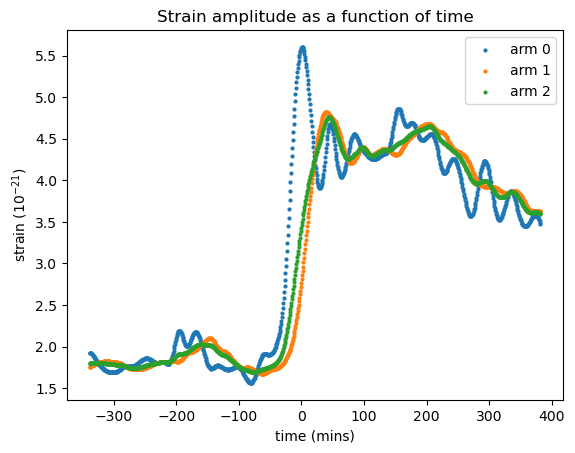

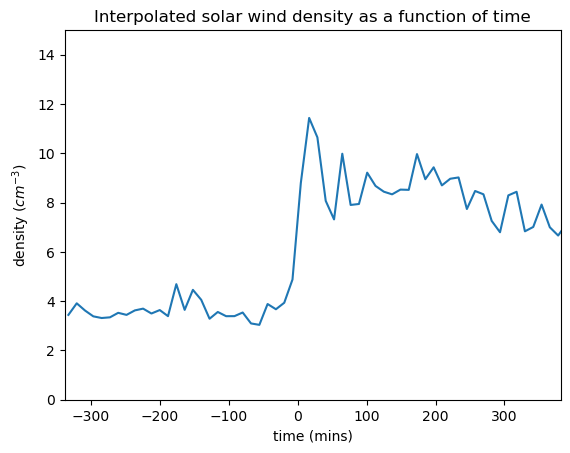

'\nspldens = spin.CubicSpline((fracday - timeoftrans) * 24*60, densities)\nx= np.linspace(np.min((fracday - timeoftrans) * 24*60), np.max((fracday - timeoftrans) * 24*60), 10000) #temporary code for spline plotting\npy.plot(x, spldens(x))\npy.xlim(time[0]/(60), time[-1]/(60))\npy.ylim(0,15)\npy.show()\n'

In [399]:
for i in averages:
    
    py.scatter(time/60, averages[i] * K * 10**21, s=4, label='arm ' +i[-1:]) #for each arm, plot for all angles
py.title('Strain amplitude as a function of time')
py.xlabel('time (mins)')
py.ylabel('strain ($10^{-21}$)') #labelling output graph
py.legend()
py.show()

py.plot((fracday - timeoftrans) * 24*60, densities)
py.xlim(time[0]/(60), time[-1]/(60))
py.ylim(0,15)
py.title('Interpolated solar wind density as a function of time')
py.xlabel('time (mins)')
py.ylabel('density ($cm^{-3}$)')
py.show()

'''
spldens = spin.CubicSpline((fracday - timeoftrans) * 24*60, densities)
x= np.linspace(np.min((fracday - timeoftrans) * 24*60), np.max((fracday - timeoftrans) * 24*60), 10000) #temporary code for spline plotting
py.plot(x, spldens(x))
py.xlim(time[0]/(60), time[-1]/(60))
py.ylim(0,15)
py.show()
'''

Strain change over time. Numerical derivative of strain, currently change per second. 

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_8704\906895640.py:8: SyntaxWarning: invalid escape sequence '\D'
  py.title('Strain change ($\Delta strain$) as a function of time')
C:\Users\User\AppData\Local\Temp\ipykernel_8704\906895640.py:10: SyntaxWarning: invalid escape sequence '\D'
  py.ylabel('$\Delta Strain$ per second ($10^{-24}$)') #labelling output graph


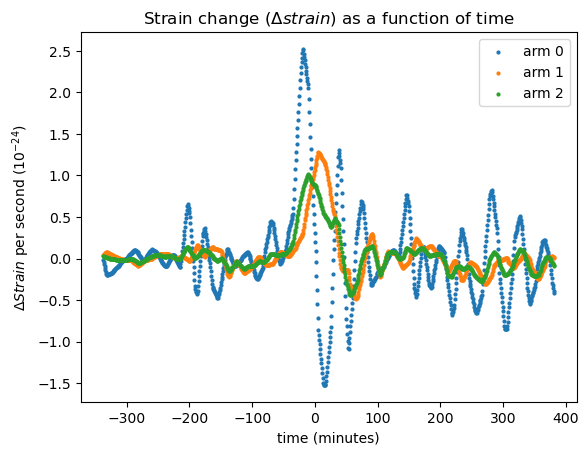

In [400]:
deltatime = time[1] - time[0] #difference between time samples (seconds)

for i in averages:
    
    py.scatter(time[1:]/60, (averages[i][1:] - averages[i][:-1]) * K * 10**24 / deltatime, s=4, label='arm ' +i[-1:]) #for each arm, plot for all angles
    #py.scatter(time[1:]/60, (averages[i][1:] - averages[i][:-1]) * 10**4 / deltatime, s=4, label='arm ' +i[-1:]) #for testing purposes
    
py.title('Strain change ($\Delta strain$) as a function of time')
py.xlabel('time (minutes)')
py.ylabel('$\Delta Strain$ per second ($10^{-24}$)') #labelling output graph
py.legend()
py.show()

Temporary check - subtracts LISA's average density from each element. Result is that when the lines overlap, all 3 overlap. There is never a situation where 2 overlap and a third doesn't. Not sure why this is. 

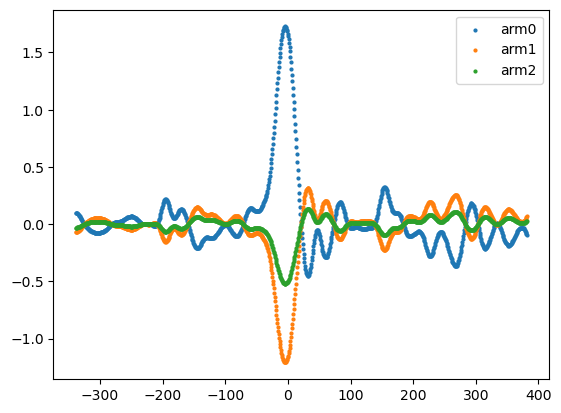

In [401]:
'''
t1 = averages['avgdens0'] - averages['avgdens1'] #arm differences
t2 = averages['avgdens1'] - averages['avgdens2']
t3 = averages['avgdens2'] - averages['avgdens0']

py.scatter(time/60, t1 * K * 10**21, s=4, label='arm__0')
py.scatter(time/60, t2 * K * 10**21, s=4, label='arm__1')
py.scatter(time/60, t3 * K * 10**21, s=4, label='arm__2')
py.legend()

'''

avgavg = (averages['avgdens0'] + averages['avgdens1'] + averages['avgdens2'] )/ 3

rev1=averages['avgdens0'] - avgavg
rev2=averages['avgdens1'] - avgavg
rev3=averages['avgdens2'] - avgavg

py.scatter(time/60, rev1 * K * 10**21, s=4, label='arm0')
py.scatter(time/60, rev2 * K * 10**21, s=4, label='arm1') #average density over the whole arm removed (so overall average becomes 0)
py.scatter(time/60, rev3 * K * 10**21, s=4, label='arm2')
py.legend()
py.show()


Text(0, 0.5, 'Unnormalized amplitude ($1/\\sqrt{Hz}$)')

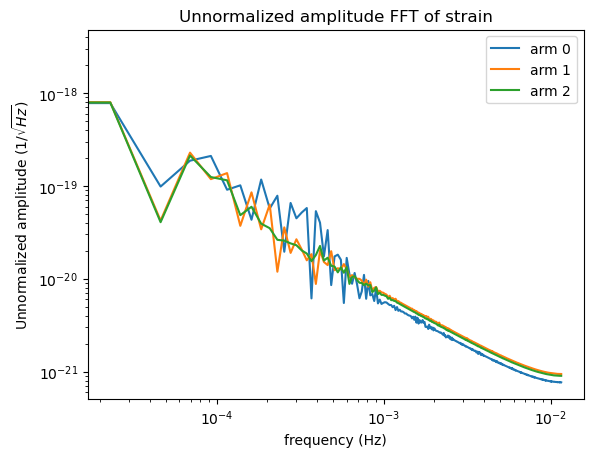

In [402]:
freqs = np.fft.rfftfreq(time.size, d=deltatime) #time in sec
fftresult = {}
for i in averages:
    fftresult['fft'+str(i[-1:])] = np.fft.rfft((averages[i])*K, norm='backward')
    
for i in fftresult:
    py.loglog(freqs, np.abs(fftresult[i]), label='arm ' +i[-1:]) #note that complex values are here, which are being 'thrown away'. part 2 - using abs() gets the amplitude correctly (I think)
py.legend()
py.title('Unnormalized amplitude FFT of strain')
py.xlabel('frequency (Hz)')
py.ylabel('Unnormalized amplitude ($1/\\sqrt{Hz}$)')


In [403]:
deltafreq = freqs[1] - freqs[0]
normfftresult = {}
for i in range(3):
    
    timeint = np.sum((averages['avgdens' + str(i)] * K)**2)*deltatime
    freqint = np.sum(np.abs(fftresult['fft' + str(i)])**2)*deltafreq * 2
    print(timeint/freqint)
    normfftresult['fft' + str(i)] = fftresult['fft' + str(i)] * timeint/freqint
    #normfftresult['fft' + str(i)] = fftresult['fft' + str(i)] * 2/graphres 

1000.1763966275935
1002.0233692044901
998.9916123383503


Text(0, 0.5, 'Normalized amplitude ($1/\\sqrt{Hz}$)')

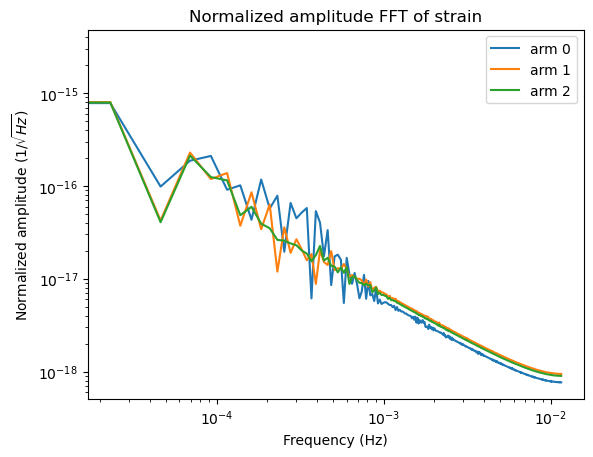

In [404]:
for i in normfftresult:
    py.loglog(freqs, np.abs(normfftresult[i]), label='arm ' +i[-1:])
py.legend()
py.title('Normalized amplitude FFT of strain')
py.xlabel('Frequency (Hz)')
py.ylabel('Normalized amplitude ($1/\\sqrt{Hz}$)')

In [405]:
print(deltatime)
print(deltafreq)
print(freqs[-1])
print(1/(2*deltatime))
print((1/deltafreq)/60)
np.sqrt(deltatime/graphres)

43.24324324324334
2.312499999999995e-05
0.011562499999999974
0.011562499999999974
720.7207207207224


0.20795009796401479

In [406]:
#Assume normalized

In [407]:
def michelsonV1(eta_ab, eta_ac, phaseshift):
    
    return (1 + phaseshift - (phaseshift**2) - (phaseshift**3)) * (eta_ab - eta_ac)

0.06012032085561497


Text(0, 0.5, 'TDI interferometer intensity')

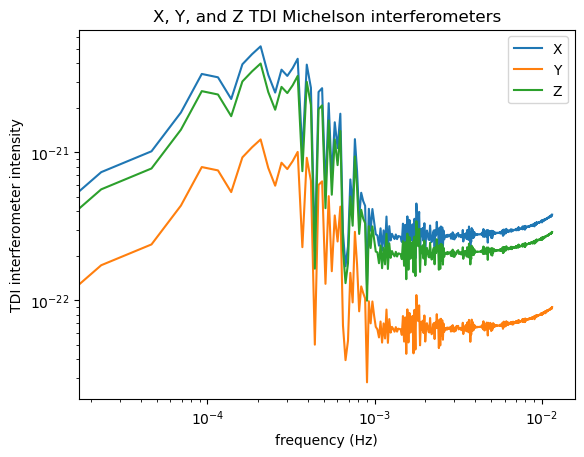

In [409]:
c = 2.998E8 #m/s
dist = L * AUtokm * 1000 #lisa arm in meters
timedelay = dist/c
basefreq = 1/timedelay

phaseshift = np.exp(1j * 2*np.pi * freqs/basefreq) #equivalent to multiplying by timedelay - but this is more clear on the logic

X = michelsonV1(fftresult['fft0'], fftresult['fft1'], phaseshift)
Y = michelsonV1(fftresult['fft1'], fftresult['fft2'], phaseshift)
Z = michelsonV1(fftresult['fft2'], fftresult['fft0'], phaseshift)

py.loglog(freqs, np.abs(X), label = 'X')
py.loglog(freqs, np.abs(Y), label = 'Y')
py.loglog(freqs, np.abs(Z), label = 'Z')
print(basefreq/2)

py.legend()
py.title('X, Y, and Z TDI Michelson interferometers')
py.xlabel('frequency (Hz)')
py.ylabel('TDI interferometer intensity')

In [380]:
#frequency integral changing (or not)

#also, test some assumptions to see whether they are valid

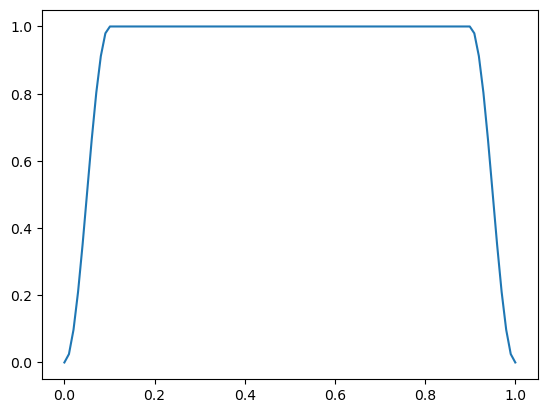

In [381]:
py.plot(np.linspace(0,1,100), spsi.windows.tukey(100,0.2))

In [382]:
with open('C:\\Users\\User\\Desktop\\XYZ\\no_window.txt', 'w') as f:
    for i in X: #[1:] removes the 'zero' frequency
        f.write(str(i) + ' ' )
    f.write('\n')
    for j in Y:
        f.write(str(j) + ' ' )
    f.write('\n')
    for k in Z:
        f.write(str(k) + ' ' )
    f.write('\n')
    for l in freqs:
        f.write(str(l) + ' ' )
    f.write('\n')
    for m in time:
        f.write(str(m) + ' ' )
    f.write('\n')


In [383]:
numfac = 10
scalefac = 1

temptest = (np.random.rand(graphres*numfac)) * scalefac #noisy
movedown = (np.sum(temptest) - np.sum(temptest[0::numfac]))/(graphres*(numfac-1)) #change each value by sum(temptest)/Npoints. Except, each 10th element will be 0, so only other 9 elements should change
temptest -= movedown
temptest[0::numfac] = 0 #set noise of each 10th element to 0

#print(np.sum(temptest))

temptest2 = np.zeros(graphres*numfac) #duplicated

for i in range(numfac):
    temptest[i::numfac] += averages['avgdens0']
    temptest2[i::numfac] = averages['avgdens0']


print(temptest)
print(temptest2)
print(np.sum(averages['avgdens0']))
print(np.sum(temptest))
print(np.sum(temptest2))
#every 10th sample (starting from first) is original data, rest are original data, with some random noise added to it - temptest2 is just duplicated 10x. 
#next step is to do FFT on temptest and temptest2 and see the difference (also do fft on the original averages[avgdens0], but that's visible above)
#also, try an inverse transform with 10x the samples, where last 9x are 0?

[3.79575068 4.13896872 3.68993972 ... 6.62751197 6.65680608 6.42136246]
[3.79575068 3.79575068 3.79575068 ... 6.8368818  6.8368818  6.8368818 ]
6290.332241349632
62903.3224134963
62903.32241349631


In [384]:
print(freqs[0])
print(1/freqs[1])
print(0.5*86400)

0.0
43243.24324324334
43200.0


(11000, 3)
-7.069824715118171e-23


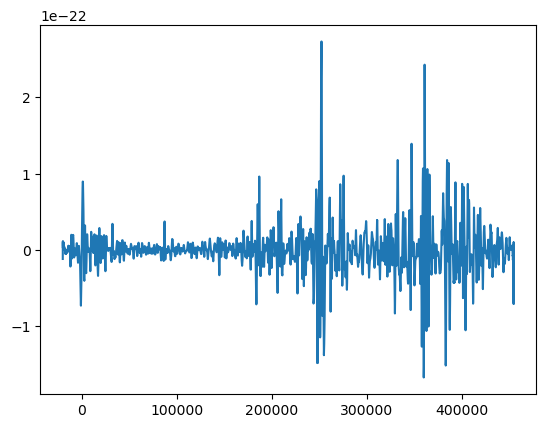

In [176]:
XYZ = np.stack([X,Y,Z]).T
invXYZ = np.fft.irfft(XYZ, axis=0)#note - normalization?
print(np.shape(invXYZ))

py.plot(time, invXYZ[:,0])
#py.plot(time, invXYZ[:,1])
#py.plot(time, invXYZ[:,2])
#py.plot(time, np.fft.irfft(X))
print(invXYZ[-1,0])

In [177]:
#Next steps
#check time-series of chirp waveform (extract from data.py output) and compare to interplanetary medium (not noise ;)) time series (the x,y,z tdi stuff, not strain)
#vary some parameters (like mass, dist, duration, t_ref, etc.), and see how that impacts offset (try with regular noise or 10/100x noise)
#try worst-case scenario for density (so using heaviside step function, ie. the first one), and see how that changes stuff (hence the time series)
#maybe also use tukey window
#find X,Y,Z for finalboy and finalline and use em in the param estimation (put this part in final report)

In [ ]:
#Qs for tomorrow
#jennrich et al - only radial data, no azimuthal
#link Christian's github too? I changed code a decent bit soo...?
#what exactly am I conveying in report? what are 'results'?
#'correct' values for blackhole params (ie. limits)?
#pytdi docs are local HTML files, how to reference?